# 從腫瘤細胞影像預測乳癌--使用類神經網路為基底的羅吉斯回歸

用以下函數來模擬多層神經網路如何解決羅吉斯回歸：

 $\textbf{y} = sigmoid(\textbf{A}_{3} \times sigmoid(\textbf{A}_{2} \times sigmoid(\textbf{A}_{1} \times \textbf{x} + \textbf{b}_{1}) + \textbf{b}_{2}) + \textbf{b}_{3})$      
 #### 2 hide layer & 1 output layer

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
import os.path
import csv
from tensorflow.python.framework import ops

# reset computational graph
ops.reset_default_graph()   

## 一、資料預處理


### 欄位資訊：
```

目標變數：
Diagnosis (1 = malignant(惡性), 0 = benign(良性)) 

解釋變數(以下10個特徵又各包含平均、標準誤、最差，共30個變數)：
a) radius (mean of distances from center to points on the perimeter) 
b) texture (standard deviation of gray-scale values) 
c) perimeter 
d) area 
e) smoothness (local variation in radius lengths) 
f) compactness (perimeter^2 / area - 1.0) 
g) concavity (severity of concave portions of the contour) 
h) concave points (number of concave portions of the contour) 
i) symmetry 
j) fractal dimension ("coastline approximation" - 1)
```
Ref: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

### 預覽資料集

In [45]:
import pandas as pd
df = pd.read_csv("BreastCancerData_MBto10.csv",names = ["diagnosis","radius_mean", "texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave_points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave_points_worst","symmetry_worst","fractal_dimension_worst"])
df.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 將資料集寫入記憶體

In [92]:
# name of data file
BreastCancerData_file = 'BreastCancerData_MBto10.csv'
# read birth weight data into memory
BreastCancerData = []
with open(BreastCancerData_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        BreastCancerData.append(row)
BreastCancerData = [[float(x) for x in row] for row in BreastCancerData]
head, *tail = BreastCancerData
print(head)

[1.0, 17.99, 10.38, 122.8, 1001.0, 0.1184, 0.2776, 0.3001, 0.1471, 0.2419, 0.07871, 1.095, 0.9053, 8.589, 153.4, 0.006399, 0.04904, 0.05373, 0.01587, 0.03003, 0.006193, 25.38, 17.33, 184.6, 2019.0, 0.1622, 0.6656, 0.7119, 0.2654, 0.4601, 0.1189]


### 分出目標變數Ｙ、解釋變數Ｘ

In [60]:
# Pull out target variable
y_vals = np.array([x[0] for x in birth_data])
# Pull out predictor variables 
x_vals = np.array([x[1:32] for x in birth_data])
print(y_vals)
print(x_vals)
print(x_vals.shape)
print(y_vals.shape)
print(np.transpose([y_vals]).shape)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.

### 設定種子

In [61]:
seed = 99
np.random.seed(seed)
tf.set_random_seed(seed)

### 宣告  batch_size

In [62]:
batch_size = 90

### 將資料及分為training set  80% / testing test  20%

In [63]:
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

### 將各欄位標準化到0,1之間

In [64]:
# Normalize by column (min-max norm)
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)

### 將Ｎ/A變為數值

In [65]:
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

## 二、定義 Tensorflow 計算圖

In [72]:
# Create graph
sess = tf.Session()

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 30], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)


# Create variable definition
def init_variable(shape):
    return(tf.Variable(tf.random_normal(shape=shape)))


# Create a logistic layer definition
def logistic(input_layer, multiplication_weight, bias_weight, activation = True):
    linear_layer = tf.add(tf.matmul(input_layer, multiplication_weight), bias_weight)
    # We separate the activation at the end because the loss function will
    # implement the last sigmoid necessary
    if activation:    #如果有定義activation，就在跑一次activation
        return(tf.nn.sigmoid(linear_layer))
    else:
        return(linear_layer)


# First logistic layer (7 inputs to 7 hidden nodes)
A1 = init_variable(shape=[30,30])
b1 = init_variable(shape=[30])
logistic_layer1 = logistic(x_data, A1, b1)

# Second logistic layer (7 hidden inputs to 5 hidden nodes)
A2 = init_variable(shape=[30,10])
b2 = init_variable(shape=[10])
logistic_layer2 = logistic(logistic_layer1, A2, b2)

# Final output layer (5 hidden nodes to 1 output)
A3 = init_variable(shape=[10,1])
b3 = init_variable(shape=[1])
final_output = logistic(logistic_layer2, A3, b3, activation=False)

# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=final_output, labels=y_target))

# Declare optimizer
my_opt = tf.train.AdamOptimizer(learning_rate = 0.002)      #不用梯度下降，改用亞當當作求loss的演算法
train_step = my_opt.minimize(loss)

## 三、訓練模型

In [73]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Actual Prediction
prediction = tf.round(tf.nn.sigmoid(final_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
# sess = tf.Session()
# print(sess.run(tf.cast(tf.equal([1,2], [1,1]), tf.float32)))
accuracy = tf.reduce_mean(predictions_correct)

writer = tf.summary.FileWriter("ImproveLinear/", graph = sess.graph)

# Training loop
loss_vec = []
train_acc = []
test_acc = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    temp_acc_train = sess.run(accuracy, feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    temp_acc_test = sess.run(accuracy, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)
    if (i+1)%150==0:
        print('Loss = ' + str(temp_loss))
sess.close()

Loss = 0.20350035
Loss = 0.1436599
Loss = 0.107304625
Loss = 0.11810744
Loss = 0.11727526
Loss = 0.07444616
Loss = 0.03196708
Loss = 0.04000479
Loss = 0.018402467
Loss = 0.04250622


## 四、評估

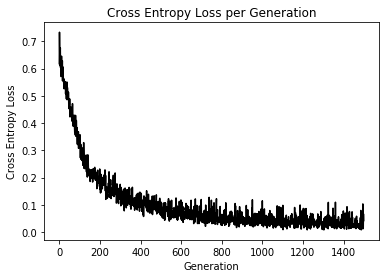

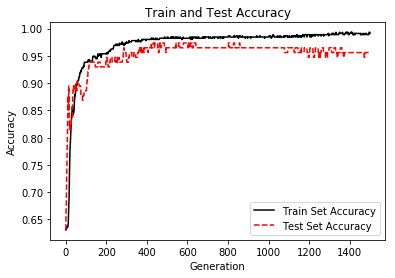

In [74]:
%matplotlib inline
# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [85]:
for i in range(1500):
    if (i+1)%10==0:
        print('第',i,'次準確率：',test_acc[i])

第 9 次準確率： 0.7982456
第 19 次準確率： 0.81578946
第 29 次準確率： 0.8333333
第 39 次準確率： 0.8947368
第 49 次準確率： 0.88596493
第 59 次準確率： 0.9035088
第 69 次準確率： 0.8947368
第 79 次準確率： 0.877193
第 89 次準確率： 0.877193
第 99 次準確率： 0.88596493
第 109 次準確率： 0.9122807
第 119 次準確率： 0.9385965
第 129 次準確率： 0.9385965
第 139 次準確率： 0.9385965
第 149 次準確率： 0.9298246
第 159 次準確率： 0.9385965
第 169 次準確率： 0.9385965
第 179 次準確率： 0.9298246
第 189 次準確率： 0.9298246
第 199 次準確率： 0.9385965
第 209 次準確率： 0.9298246
第 219 次準確率： 0.9385965
第 229 次準確率： 0.9385965
第 239 次準確率： 0.9385965
第 249 次準確率： 0.9385965
第 259 次準確率： 0.9385965
第 269 次準確率： 0.9385965
第 279 次準確率： 0.9385965
第 289 次準確率： 0.95614034
第 299 次準確率： 0.94736844
第 309 次準確率： 0.9385965
第 319 次準確率： 0.95614034
第 329 次準確率： 0.94736844
第 339 次準確率： 0.95614034
第 349 次準確率： 0.94736844
第 359 次準確率： 0.95614034
第 369 次準確率： 0.9649123
第 379 次準確率： 0.9649123
第 389 次準確率： 0.9649123
第 399 次準確率： 0.9649123
第 409 次準確率： 0.9649123
第 419 次準確率： 0.9649123
第 429 次準確率： 0.9649123
第 439 次準確率： 0.9736842
第 449 次準確率： 0.9736842
第 459 次準確率： 0